<a href="https://colab.research.google.com/github/cselmo/ECI23-3D/blob/main/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercio 1 : Modelo Lineal Generativo

El objetivo de este ejercicio es construir y analizar un modelo lineal generativo a partir de una pequeña base de datos.

Para ello:
1. Cargar la base de datos de entrenamiento (se provee el código para bajar los meshes en formato .obj abajo)
2. Crear un modelo PCA a partir de los datos. Mantener las K componentes principales que explican el 95% de la varianza.
3. Analizar qué ocurre cuando se varía solamente la primera/segunda/tercera componente principal (visualizar extremos de la distribución).
4. Generar 5 meshes aleatorios.
5. Cargar el sujeto de testing (se provee código), y proyectar al modelo. ¿Cuán bien generaliza el modelo? ¿A qué se debe?


*La base de datos fue obtenida de https://faces.dmi.unibas.ch/bfm/index.php?nav=1-1-1&id=scans (no es necesario bajar de vuelta)*

## Setup

In [1]:
! pip install trimesh
! pip install --upgrade gdown
! pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.3/686.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6


In [2]:
import gdown
import os
import numpy as np
import trimesh

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
gdown.download("https://drive.google.com/uc?id=168f0X6rYWEsOLCABHTeeShEV__P58csI", "training-data.zip", quiet=False)
! unzip -d . training-data.zip

Downloading...
From: https://drive.google.com/uc?id=168f0X6rYWEsOLCABHTeeShEV__P58csI
To: /content/training-data.zip
100%|██████████| 19.6M/19.6M [00:00<00:00, 26.6MB/s]


Archive:  training-data.zip
  inflating: ./training-data/00001_20061015_00418_neutral_face05.obj  
  inflating: ./training-data/00002_20061015_00448_neutral_face05.obj  
  inflating: ./training-data/00014_20080430_04338_neutral_face05.obj  
  inflating: ./training-data/00017_20061201_00812_neutral_face05.obj  
  inflating: ./training-data/00021_20061127_00715_neutral_face05.obj  
  inflating: ./training-data/00022_20070307_02486_neutral_face05.obj  
  inflating: ./training-data/00052_20061024_00526_neutral_face05.obj  
  inflating: ./training-data/00293_20080104_03413_neutral_face05.obj  
  inflating: ./training-data/00323_20080125_03764_neutral_face05.obj  


In [5]:
from pathlib import Path

## 1. Cargar datos

- Los meshes se encuentran en el directorio 'training-data'.
- Para cargar un mesh: ```trimesh.load('path/to/meshfile.obj')```
- Sugerencia: guardar también la lista de caras, para poder visualizar más adelante.


In [6]:
## Cargo los meshes y los dejo en una lista que contiene a cada uno de los mesh.
files = Path("training-data/").glob("**/*obj")
data = [trimesh.load(file) for file in files]
mesh_names = [f'Cara {idx}' for idx in range(1,10)] #Nombre que le asigno a cada mesh

In [7]:
#Me fijo la cantidad de vértices que tiene cada cara.
data[0].faces.shape

(106466, 3)

# La siguiente celda tarda 5 minutos en correr. Si se usó meshlab para explorar los obj, saltearla.

CPU times: user 6.12 s, sys: 1.62 s, total: 7.73 s
Wall time: 6.12 s


(-150000.0, 150000.0, -150000.0, 150000.0)

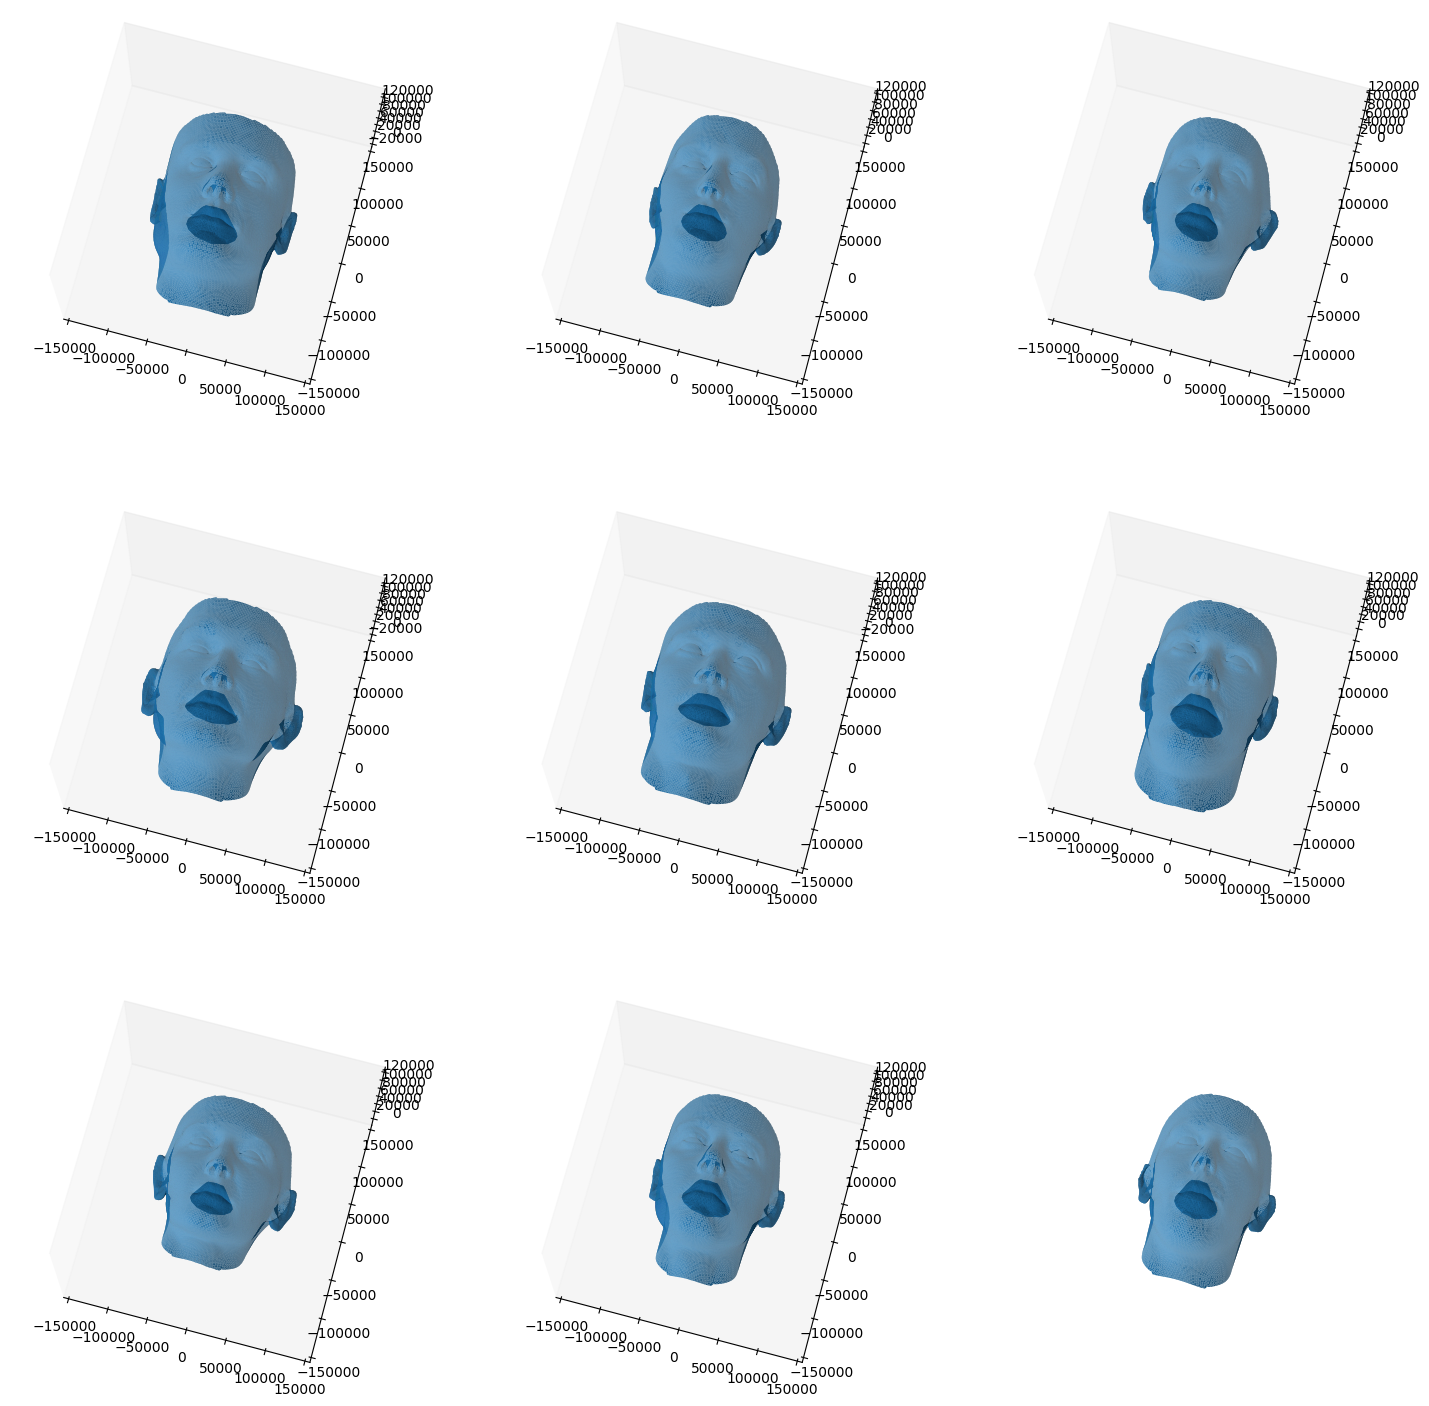

In [ ]:
%%time
#Grafico las caras para tener idea de cómo son.
# Para verlas mejor se recomienda usar meshlab.

fig = plt.figure(figsize=[18,18])
for idx in range(3):
    for idy in range(3):
        index = 3*idx+idy
        vertices = meshes_data[index].vertices
        faces = meshes_data[index].faces
        ax = fig.add_subplot(3,3,index+1, projection='3d')
        ax.view_init(elev=90, azim=-90, roll=0)
        ax.plot_trisurf(
            vertices[:, 0],
            vertices[:,1],
            Z = vertices[:,2],
            triangles=faces)
        ax.set_xlim([-150000,150000])
        ax.set_ylim([-150000,150000])
        ax.grid(False)
        ax.set_title(mesh_names[index])
        plt.axis('off')


In [9]:
# Hago un flatten para tener vectores 1D a los que aplicarle PCA.
data_flatten = np.array([obj.vertices.flatten() for obj in data])

## 2. Construir modelo

Calcular:
- La matriz de componentes principales.
- La cara media.
- La varianza / desviación estándar asociada a cada una de las componentes principales.

Conservar las K primeras componentes principales que explican el 95% de la varianza.

Sugerencia: ver la función 'PCA' de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [10]:
from sklearn.decomposition import PCA

In [11]:
# Verifico que el flatten se haya hecho correctamente
data_flatten.shape

(9, 160470)

Entreno PCA con la máxima cantidad permitida de componentes para analizar la varianza explicada

In [12]:
trf = PCA(9, svd_solver='randomized')
trf.fit(data_flatten)

PCA(n_components=9, svd_solver='randomized')

In [13]:
trf.explained_variance_ratio_.cumsum()

array([0.60116045, 0.72518112, 0.8302369 , 0.88719059, 0.93489698,
       0.9676709 , 0.98994227, 1.        , 1.        ])

Con 6 componentes explico el 95% de la varianza, asique entreno nuevamente con 6 componentes.

In [14]:
trf = PCA(6, svd_solver='randomized')
trf.fit(data_flatten)

PCA(n_components=6, svd_solver='randomized')

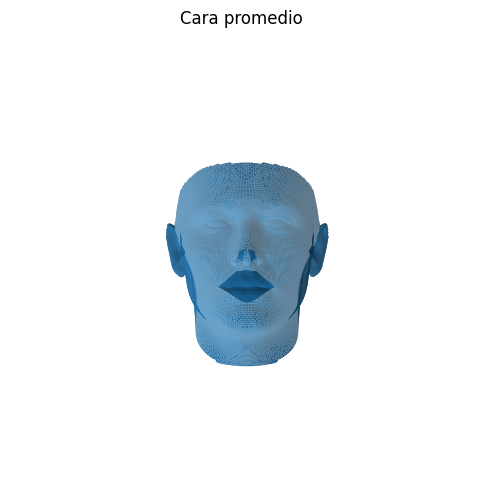

In [ ]:
fig = plt.figure(figsize=[6,6])
vertices = trf.mean_.reshape(-1,3)
faces = data[0].faces
ax = fig.add_subplot(1,1,1, projection='3d')
ax.view_init(elev=90, azim=-90, roll=0)
ax.plot_trisurf(
    vertices[:, 0],
    vertices[:,1],
    Z = vertices[:,2],
    triangles=faces)
ax.set_xlim([-150000,150000])
ax.set_ylim([-150000,150000])
ax.grid(False)
ax.set_title('Cara promedio')
plt.axis('off')
plt.show()

Guardar cara media y chequear en meshlab que esté todo bien:

In [15]:
# save
mesh = trimesh.Trimesh(vertices=trf.mean_.reshape(-1,3), faces=data[0].faces)
mesh.export('mean.obj');

# download
from google.colab import files
files.download('mean.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. ¿Qué ocurre al variar las primeras tres componentes principales?

Hint:

- Generar vectores latentes (dimensión d) tales que sólo el primer (segundo/tercero) coeficiente sea distinto de cero.
- Valor del coeficiente distinto de cero: explorar qué pasa en los extremos de la distribución (+- 3 std).
- Reconstruir a partir del vector latente.


In [16]:
data_trf = trf.transform(data_flatten)

In [17]:
# Verifico que el promedio de cada coeficiente del vector de PCA sea cero (o casi)
data_trf.mean(axis = 0)

array([-2.58700715e-11, -1.35817875e-10,  1.53603550e-10,  6.79089377e-11,
       -7.35680159e-11,  0.00000000e+00])

In [18]:
# Calculo los desvíos estandar
data_trf.std(axis = 0)

array([1152639.60666487,  523534.5827704 ,  481846.06065172,
        354780.09569472,  324703.24659655,  269130.27406086])

Vamos a generar caras con las primeras componentes a -3,-2,-1,1, 2 y 3 desvíos estandar.

In [19]:
meshes_std = list()
meshes_std_names = list()
std = data_trf.std(axis = 0)
for dim in range(3):
    for num_std in [-3,-2,-1,1,2,3]:
        coeffs = np.zeros(6)
        coeffs[dim] = std[dim]*num_std
        mesh1 = trf.inverse_transform([coeffs])
        mesh = trimesh.Trimesh(vertices=mesh1[0].reshape(-1,3), faces=data[0].faces)
        filename = f'mesh_dim={dim}_std={num_std}.obj'
        mesh.export(filename);
        #files.download(filename)
        meshes_std.append(mesh)
        meshes_std_names.append(filename)

CPU times: user 15.4 s, sys: 2.92 s, total: 18.3 s
Wall time: 16.5 s


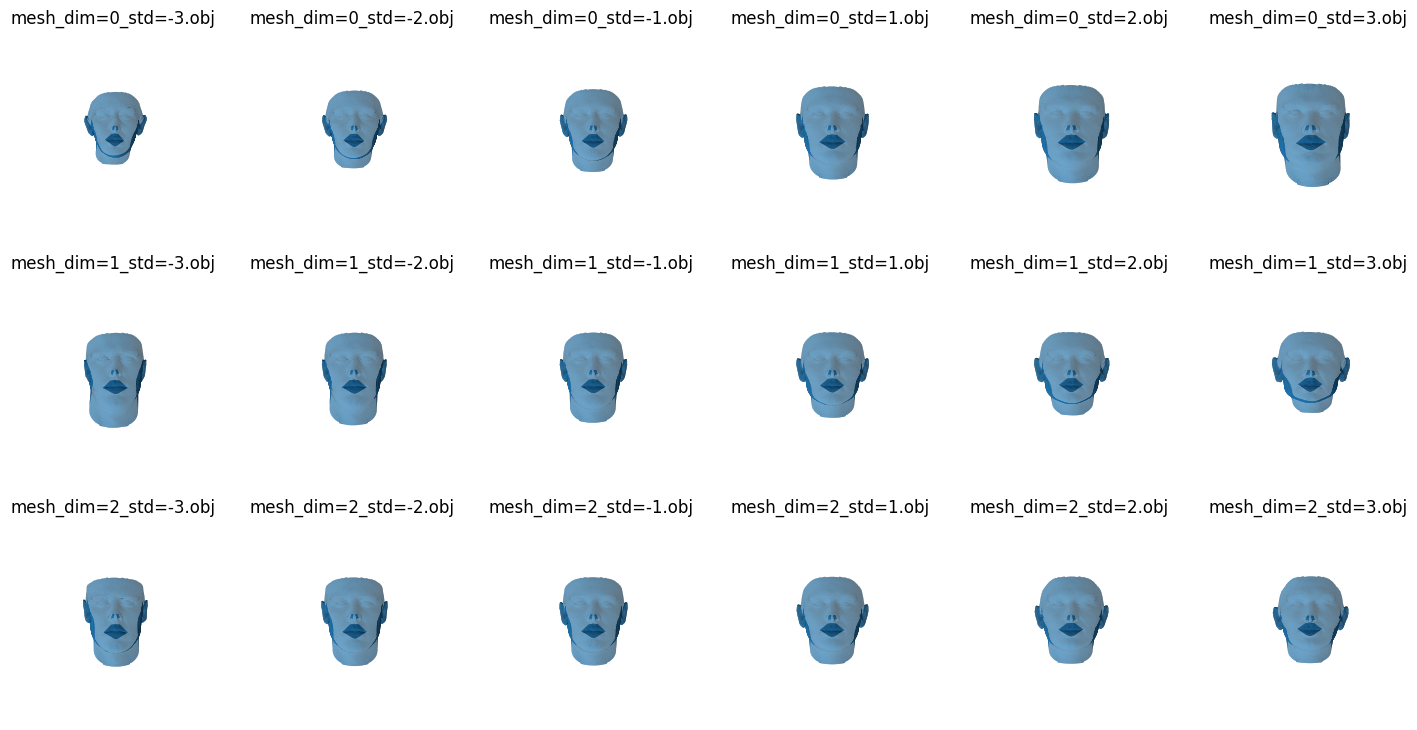

In [ ]:
%%time
#Grafico las caras generadas para tener idea de cómo son.
#Para verlas mejor se recomienda usar meshlab.

fig = plt.figure(figsize=[18,9])
for idx in range(6):
    for idy in range(3):
        index = 3*idx+idy
        vertices = meshes_std[index].vertices
        faces = meshes_std[index].faces
        ax = fig.add_subplot(3,6,index+1, projection='3d')
        ax.view_init(elev=90, azim=-90, roll=0)
        ax.plot_trisurf(
            vertices[:, 0],
            vertices[:,1],
            Z = vertices[:,2],
            triangles=faces)
        ax.set_xlim([-150000,150000])
        ax.set_ylim([-150000,150000])
        ax.grid(False)
        ax.set_title(meshes_std_names[index])
        plt.axis('off')

Según lo visto, la primera dimensión parecería estar vinculada al tamaño de la cara. La segunda dimensión al ancho de la cara, y la tercera al largo de la misma.

### 4. Instancias Aleatorias

Generar 5 instancias aleatorias con el modelo.

In [ ]:
means = data_trf.mean(axis = 0)
std = data_trf.std(axis = 0)

In [ ]:
random_faces = np.array([[np.random.normal(means[idx], std[idx]) for idx in range(6)] for _ in range(5)])

In [ ]:
random_meshs = trf.inverse_transform(random_faces)

In [ ]:
meshes_rand = []
for idx,random_mesh in enumerate(random_meshs):
    meshes_rand.append(trimesh.Trimesh(vertices=random_mesh.reshape(-1,3), faces=data[0].faces))
    filename = f'random_mesh{idx}.obj'
    meshes_rand[-1].export(filename);
    files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 2.75 s, sys: 950 ms, total: 3.7 s
Wall time: 2.85 s


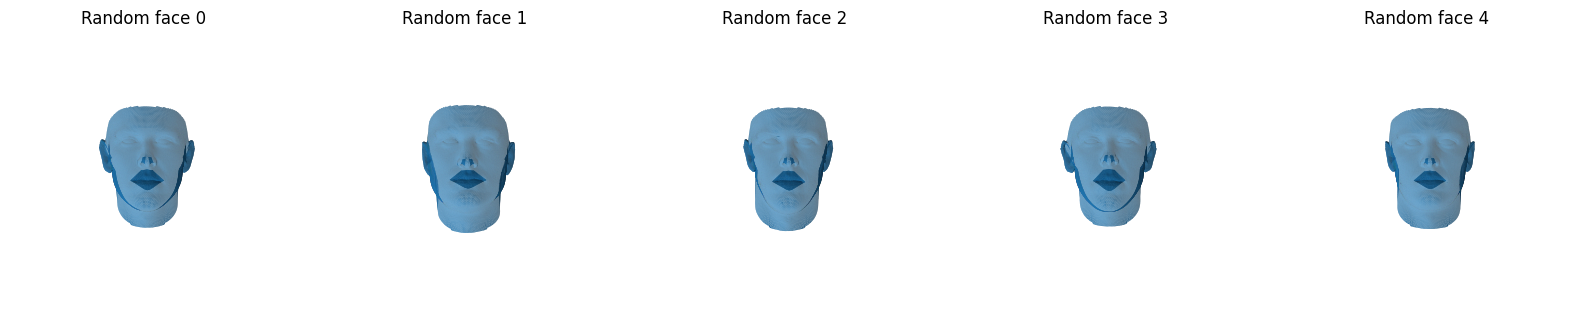

In [ ]:
%%time
#Grafico las caras generadas para tener idea de cómo son.
#Para verlas mejor se recomienda usar meshlab.

fig = plt.figure(figsize=[20,4])
for index in range(5):
    vertices = meshes_rand[index].vertices
    faces = meshes_rand[index].faces
    ax = fig.add_subplot(1,5,index+1, projection='3d')
    ax.view_init(elev=90, azim=-90, roll=0)
    ax.plot_trisurf(
        vertices[:, 0],
        vertices[:,1],
        Z = vertices[:,2],
        triangles=faces)
    ax.set_xlim([-150000,150000])
    ax.set_ylim([-150000,150000])
    ax.grid(False)
    ax.set_title(f'Random face {index}')
    plt.axis('off')

### 5. Generalización

Se provee código que cargar un sujeto no visto por el modelo (mesh con la misma topología, que no se usó en la base de datos de entrenamiento).

Proyectar el scan al modelo, y responder:

- ¿Cuán bien generaliza el modelo? ¿A qué se debe?

Hint: "proyectar" -> obtener el vector latente, y luego reconstruir.




In [20]:
# Cargar el sujeto de testing:
gdown.download("https://drive.google.com/uc?id=18v7Xf5vKpX7aXhz6TNkFodxfvvRs-5uo", "test-mesh.obj", quiet=False)
test_mesh = trimesh.load('test-mesh.obj')
test_vertices = np.array(test_mesh.vertices)

Downloading...
From: https://drive.google.com/uc?id=18v7Xf5vKpX7aXhz6TNkFodxfvvRs-5uo
To: /content/test-mesh.obj
100%|██████████| 8.38M/8.38M [00:00<00:00, 34.7MB/s]


In [21]:
test_pca = trf.transform(test_vertices.reshape(1,-1))

In [22]:
recovered_test_vertices = trf.inverse_transform(test_pca)

In [23]:
recovered_test_mesh = trimesh.Trimesh(vertices=recovered_test_vertices[0].reshape(-1,3), faces=data[0].faces)
recovered_test_mesh.export(f'recovered_test_mesh.obj');
files.download(f'recovered_test_mesh.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 1.31 s, sys: 383 ms, total: 1.69 s
Wall time: 1.36 s


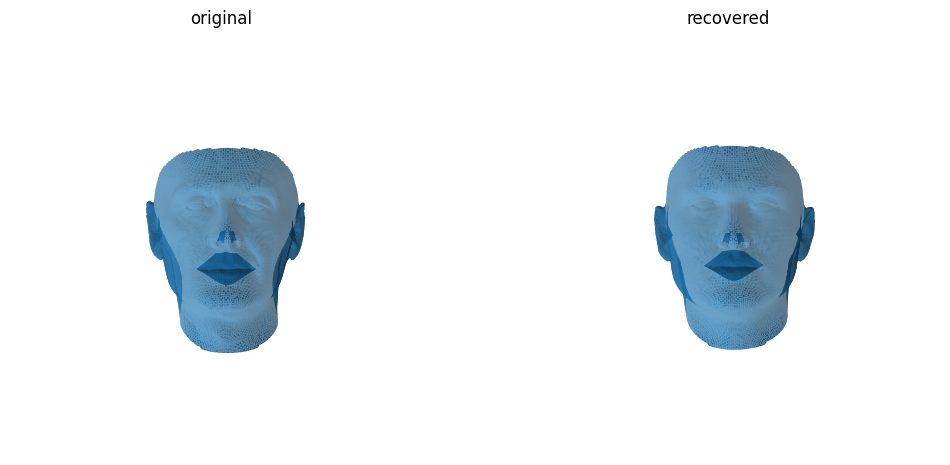

In [ ]:
%%time
#Grafico las caras de test original y la reconstruída.
#Para verlas mejor se recomienda usar meshlab.
meshes = [test_mesh, recovered_test_mesh]
names = ["original", "recovered"]
fig = plt.figure(figsize=[12,6])
for index in range(2):
    vertices = meshes[index].vertices
    faces = meshes[index].faces
    ax = fig.add_subplot(1,2,index+1, projection='3d')
    ax.view_init(elev=90, azim=-90, roll=0)
    ax.plot_trisurf(
        vertices[:, 0],
        vertices[:,1],
        Z = vertices[:,2],
        triangles=faces)
    ax.set_xlim([-150000,150000])
    ax.set_ylim([-150000,150000])
    ax.grid(False)
    ax.set_title(names[index])
    plt.axis('off')

El modelo generaliza mal en este caso ya que la cara en cuestión se encuentra por fuera de la distribución con las que fue entrenado el modelo. Para analizar en detalle las diferencias, lo mejor es abrir ambos meshs con meshlab.